<a href="https://colab.research.google.com/github/MoMedhat10/deep-learning-project/blob/main/carClassificationProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip DATA.zip

Archive:  DATA.zip
   creating: DATA/
   creating: DATA/bmw serie 1/
  inflating: DATA/bmw serie 1/back0.jpg  
  inflating: DATA/bmw serie 1/back1.jpg  
  inflating: DATA/bmw serie 1/back10.jpg  
  inflating: DATA/bmw serie 1/back11.jpg  
  inflating: DATA/bmw serie 1/back12.jpg  
  inflating: DATA/bmw serie 1/back13.jpg  
  inflating: DATA/bmw serie 1/back14.jpg  
  inflating: DATA/bmw serie 1/back15.jpg  
  inflating: DATA/bmw serie 1/back16.jpg  
  inflating: DATA/bmw serie 1/back17.jpg  
  inflating: DATA/bmw serie 1/back18.jpg  
  inflating: DATA/bmw serie 1/back19.jpg  
  inflating: DATA/bmw serie 1/back2.jpg  
  inflating: DATA/bmw serie 1/back20.jpg  
  inflating: DATA/bmw serie 1/back21.jpg  
  inflating: DATA/bmw serie 1/back22.jpg  
  inflating: DATA/bmw serie 1/back23.jpg  
  inflating: DATA/bmw serie 1/back24.jpg  
  inflating: DATA/bmw serie 1/back25.jpg  
  inflating: DATA/bmw serie 1/back26.jpg  
  inflating: DATA/bmw serie 1/back27.jpg  
  inflating: DATA/bmw serie 1/b

In [2]:
!ls /content/DATA


'bmw serie 1'	    Golf	     'mercedes class a'   sandero
'chevrolet spark'  'hyundai i10'     'nemo citroen'	 'seat ibiza'
'chevroulet aveo'  'hyundai tucson'   octavia		  symbol
 clio		    logan	      picanto		 'toyota corolla'
 duster		    megane	      polo		 'volkswagen tiguan'


In [3]:
!rm -rf /content/data


In [4]:
import os
import shutil
import random

source_dir = "/content/DATA"
base_dir = "/content/data"

splits = {
    "train": 0.7,
    "val": 0.15,
    "test": 0.15
}

os.makedirs(base_dir, exist_ok=True)

for split in splits:
    os.makedirs(os.path.join(base_dir, split), exist_ok=True)

for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    random.shuffle(images)

    n = len(images)
    train_end = int(splits["train"] * n)
    val_end = train_end + int(splits["val"] * n)

    split_files = {
        "train": images[:train_end],
        "val": images[train_end:val_end],
        "test": images[val_end:]
    }

    for split, files in split_files.items():
        split_class_dir = os.path.join(base_dir, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)

        for file in files:
            shutil.copy(
                os.path.join(class_path, file),
                os.path.join(split_class_dir, file)
            )

print("✅ Dataset split completed successfully")


✅ Dataset split completed successfully


In [5]:
!ls /content/data


test  train  val


In [6]:
!ls /content/data/train


'bmw serie 1'	    Golf	     'mercedes class a'   sandero
'chevrolet spark'  'hyundai i10'     'nemo citroen'	 'seat ibiza'
'chevroulet aveo'  'hyundai tucson'   octavia		  symbol
 clio		    logan	      picanto		 'toyota corolla'
 duster		    megane	      polo		 'volkswagen tiguan'


In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

IMAGE_SIZE = 224
BATCH_SIZE = 32

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])


val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder("/content/data/train", transform=train_transform)
val_dataset   = datasets.ImageFolder("/content/data/val", transform=val_transform)
test_dataset  = datasets.ImageFolder("/content/data/test", transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

num_classes = len(train_dataset.classes)
print("num of classes", num_classes)


num of classes 20


In [8]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


ResNet **Training**

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():
    param.requires_grad = True





model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-5
)


**Training Loop**

In [ ]:
from tqdm import tqdm

EPOCHS = 15

for epoch in range(EPOCHS):
    model.train()
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    print(f"Epoch {epoch+1}: Train Accuracy = {train_acc:.4f}")


100%|██████████| 71/71 [00:20<00:00,  3.46it/s]


Epoch 1: Train Accuracy = 0.1143


100%|██████████| 71/71 [00:19<00:00,  3.64it/s]


Epoch 2: Train Accuracy = 0.2338


100%|██████████| 71/71 [00:18<00:00,  3.76it/s]


Epoch 3: Train Accuracy = 0.2865


100%|██████████| 71/71 [00:20<00:00,  3.52it/s]


Epoch 4: Train Accuracy = 0.3357


100%|██████████| 71/71 [00:19<00:00,  3.64it/s]


Epoch 5: Train Accuracy = 0.4123


100%|██████████| 71/71 [00:19<00:00,  3.69it/s]


Epoch 6: Train Accuracy = 0.4588


100%|██████████| 71/71 [00:19<00:00,  3.60it/s]


Epoch 7: Train Accuracy = 0.5049


100%|██████████| 71/71 [00:19<00:00,  3.66it/s]


Epoch 8: Train Accuracy = 0.5593


100%|██████████| 71/71 [00:19<00:00,  3.57it/s]


Epoch 9: Train Accuracy = 0.5815


100%|██████████| 71/71 [00:19<00:00,  3.56it/s]


Epoch 10: Train Accuracy = 0.6169


100%|██████████| 71/71 [00:19<00:00,  3.67it/s]


Epoch 11: Train Accuracy = 0.6399


100%|██████████| 71/71 [00:19<00:00,  3.58it/s]


Epoch 12: Train Accuracy = 0.6572


100%|██████████| 71/71 [00:19<00:00,  3.59it/s]


Epoch 13: Train Accuracy = 0.6771


100%|██████████| 71/71 [00:19<00:00,  3.63it/s]


Epoch 14: Train Accuracy = 0.7037


100%|██████████| 71/71 [00:19<00:00,  3.55it/s]

Epoch 15: Train Accuracy = 0.7254


**Test Set**

Test Accuracy: 0.591182364729459


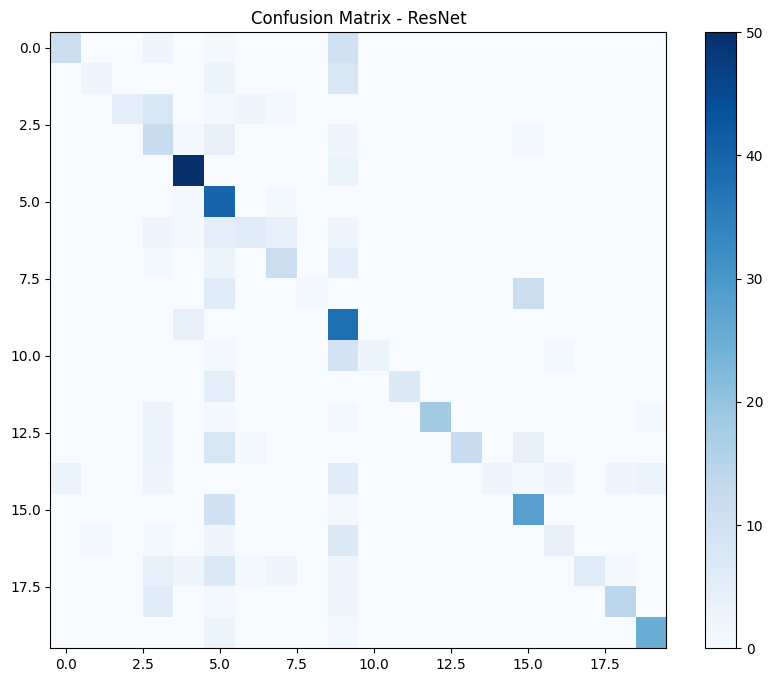

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
print("Test Accuracy:", acc)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix - ResNet")
plt.colorbar()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

class_names = test_loader.dataset.classes

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("Precision:", precision_score(y_true, y_pred, average='weighted', zero_division=0))
print("Recall:", recall_score(y_true, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_true, y_pred, average='weighted'))

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))


Precision: 0.7421625248627394
Recall: 0.591182364729459
F1 Score: 0.5698789730782513

Classification Report:

                   precision    recall  f1-score   support

             Golf       0.79      0.46      0.58        24
      bmw serie 1       0.67      0.15      0.25        13
  chevrolet spark       1.00      0.29      0.45        17
  chevroulet aveo       0.27      0.60      0.38        20
             clio       0.85      0.94      0.89        53
           duster       0.40      0.95      0.56        42
      hyundai i10       0.60      0.30      0.40        20
   hyundai tucson       0.58      0.55      0.56        20
            logan       1.00      0.06      0.11        18
           megane       0.39      0.90      0.55        42
 mercedes class a       1.00      0.21      0.35        14
     nemo citroen       1.00      0.58      0.74        12
          octavia       1.00      0.75      0.86        24
          picanto       1.00      0.43      0.60        28
    

**ROC**

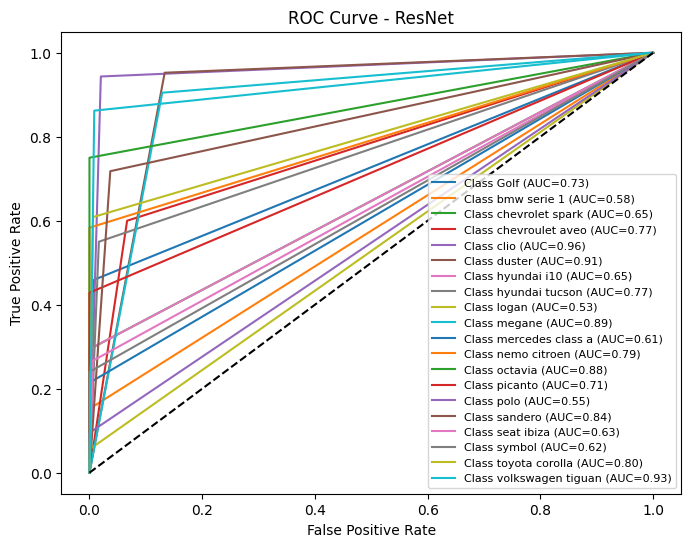

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

num_classes = len(class_names)

y_true_bin = label_binarize(y_true, classes=range(num_classes))
y_pred_bin = label_binarize(y_pred, classes=range(num_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC={roc_auc[i]:.2f})')

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - ResNet')
plt.legend(fontsize=8)
plt.show()


**MobileNet**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm


device = "cuda" if torch.cuda.is_available() else "cpu"
num_classes = len(train_dataset.classes)

print("Device:", device)
print("Num Classes:", num_classes)


Device: cuda
Num Classes: 20


In [ ]:
from torchvision.models import MobileNet_V2_Weights

model = models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 168MB/s]


In [ ]:
for param in model.parameters():
    param.requires_grad = False

# Fine-tune last feature block
for param in model.features[-1].parameters():
    param.requires_grad = True



In [ ]:
model.classifier[1] = nn.Linear(
    model.classifier[1].in_features,
    num_classes
)


In [ ]:
model = model.to(device)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4
)


**Training Loop**

In [ ]:
EPOCHS = 15

for epoch in range(EPOCHS):
    model.train()
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    print(f"Epoch [{epoch+1}/{EPOCHS}] - Train Accuracy: {train_acc:.4f}")


100%|██████████| 71/71 [00:13<00:00,  5.17it/s]


Epoch [1/15] - Train Accuracy: 0.0957


100%|██████████| 71/71 [00:13<00:00,  5.20it/s]


Epoch [2/15] - Train Accuracy: 0.1506


100%|██████████| 71/71 [00:13<00:00,  5.30it/s]


Epoch [3/15] - Train Accuracy: 0.1918


100%|██████████| 71/71 [00:13<00:00,  5.32it/s]


Epoch [4/15] - Train Accuracy: 0.2498


100%|██████████| 71/71 [00:13<00:00,  5.29it/s]


Epoch [5/15] - Train Accuracy: 0.2834


100%|██████████| 71/71 [00:13<00:00,  5.14it/s]


Epoch [6/15] - Train Accuracy: 0.3069


100%|██████████| 71/71 [00:13<00:00,  5.31it/s]


Epoch [7/15] - Train Accuracy: 0.3348


100%|██████████| 71/71 [00:13<00:00,  5.10it/s]


Epoch [8/15] - Train Accuracy: 0.3459


100%|██████████| 71/71 [00:13<00:00,  5.31it/s]


Epoch [9/15] - Train Accuracy: 0.3658


100%|██████████| 71/71 [00:13<00:00,  5.09it/s]


Epoch [10/15] - Train Accuracy: 0.3928


100%|██████████| 71/71 [00:13<00:00,  5.25it/s]


Epoch [11/15] - Train Accuracy: 0.3933


100%|██████████| 71/71 [00:13<00:00,  5.31it/s]


Epoch [12/15] - Train Accuracy: 0.4132


100%|██████████| 71/71 [00:13<00:00,  5.32it/s]


Epoch [13/15] - Train Accuracy: 0.4482


100%|██████████| 71/71 [00:13<00:00,  5.32it/s]


Epoch [14/15] - Train Accuracy: 0.4314


100%|██████████| 71/71 [00:13<00:00,  5.29it/s]

Epoch [15/15] - Train Accuracy: 0.4575


**Test Accuracy + Confusion Matrix**

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = outputs.argmax(1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
print("Test Accuracy (MobileNet):", acc)




Test Accuracy (MobileNet): 0.5150300601202404


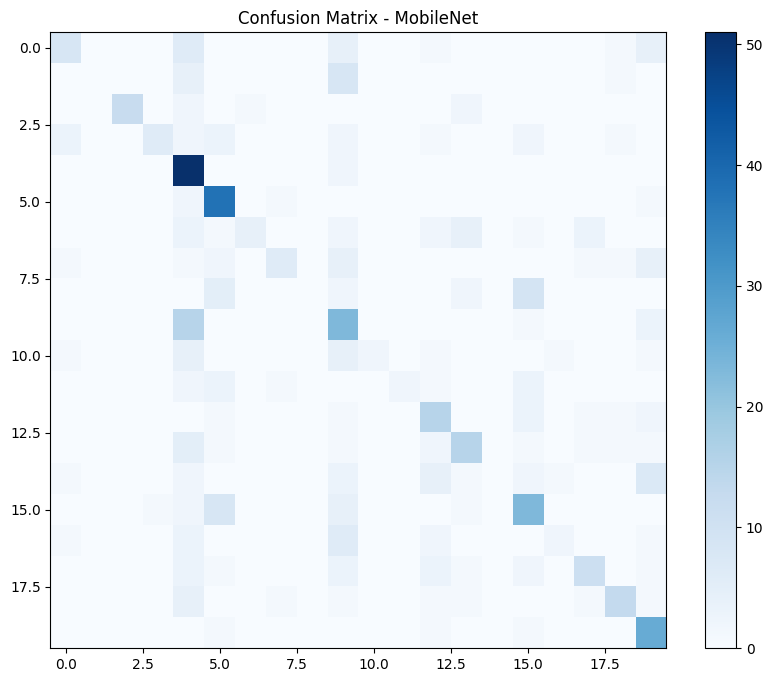

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix - MobileNet")
plt.colorbar()
plt.show()


**Precision / Recall / F1**

In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

print("Precision:", precision_score(y_true, y_pred, average='weighted', zero_division=0))
print("Recall:", recall_score(y_true, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_true, y_pred, average='weighted'))

print("\nClassification Report:\n")
print(classification_report(
    y_true,
    y_pred,
    target_names=test_loader.dataset.classes,
    zero_division=0
))




Precision: 0.5274768588381882
Recall: 0.5150300601202404
F1 Score: 0.46462173459410505

Classification Report:

                   precision    recall  f1-score   support

             Golf       0.53      0.33      0.41        24
      bmw serie 1       0.00      0.00      0.00        13
  chevrolet spark       1.00      0.71      0.83        17
  chevroulet aveo       0.86      0.30      0.44        20
             clio       0.46      0.96      0.62        53
           duster       0.59      0.90      0.72        42
      hyundai i10       0.80      0.20      0.32        20
   hyundai tucson       0.67      0.30      0.41        20
            logan       0.00      0.00      0.00        18
           megane       0.33      0.55      0.41        42
 mercedes class a       1.00      0.14      0.25        14
     nemo citroen       1.00      0.17      0.29        12
          octavia       0.44      0.62      0.52        24
          picanto       0.56      0.54      0.55        28
  

**ROC & AUC**

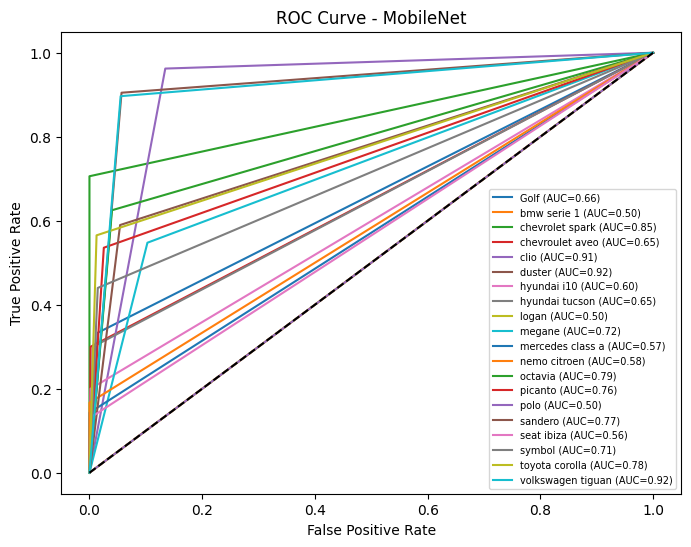

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc


class_names = test_loader.dataset.classes
num_classes = len(class_names)

y_true_bin = label_binarize(y_true, classes=range(num_classes))
y_pred_bin = label_binarize(y_pred, classes=range(num_classes))

fpr, tpr, roc_auc = {}, {}, {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC={roc_auc[i]:.2f})')

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - MobileNet')
plt.legend(fontsize=7)
plt.show()


**Inception V1**

In [ ]:
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader


INCEPTION_SIZE = 299
BATCH_SIZE = 32

train_transform_inception = transforms.Compose([
    transforms.RandomResizedCrop(INCEPTION_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

val_transform_inception = transforms.Compose([
    transforms.Resize(320),
    transforms.CenterCrop(INCEPTION_SIZE),
    transforms.ToTensor(),
])


In [ ]:
train_dataset_inc = datasets.ImageFolder(
    "/content/data/train",
    transform=train_transform_inception
)

val_dataset_inc = datasets.ImageFolder(
    "/content/data/val",
    transform=val_transform_inception
)

test_dataset_inc = datasets.ImageFolder(
    "/content/data/test",
    transform=val_transform_inception
)


train_loader_inc = DataLoader(train_dataset_inc, batch_size=BATCH_SIZE, shuffle=True)
val_loader_inc   = DataLoader(val_dataset_inc, batch_size=BATCH_SIZE, shuffle=False)
test_loader_inc  = DataLoader(test_dataset_inc, batch_size=BATCH_SIZE, shuffle=False)

num_classes = len(train_dataset_inc.classes)
print("Num Classes:", num_classes)


Num Classes: 20


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


In [ ]:
from torchvision.models import Inception_V3_Weights

model = models.inception_v3(
    weights=Inception_V3_Weights.DEFAULT
)


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 213MB/s] 


In [ ]:
for param in model.parameters():
    param.requires_grad = False


for param in model.Mixed_7c.parameters():
    param.requires_grad = True


In [ ]:
model.fc = nn.Linear(
    model.fc.in_features,
    num_classes
)


In [ ]:
model = model.to(device)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-5
)


In [ ]:
EPOCHS = 15

for epoch in range(EPOCHS):
    model.train()
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader_inc):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs, aux_outputs = model(images)

        loss1 = criterion(outputs, labels)
        loss2 = criterion(aux_outputs, labels)
        loss = loss1 + 0.4 * loss2

        loss.backward()
        optimizer.step()

        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    print(f"Epoch [{epoch+1}/{EPOCHS}] - Train Accuracy: {train_acc:.4f}")


100%|██████████| 71/71 [00:16<00:00,  4.19it/s]


Epoch [1/15] - Train Accuracy: 0.0589


100%|██████████| 71/71 [00:16<00:00,  4.23it/s]


Epoch [2/15] - Train Accuracy: 0.1333


100%|██████████| 71/71 [00:17<00:00,  3.96it/s]


Epoch [3/15] - Train Accuracy: 0.1767


100%|██████████| 71/71 [00:17<00:00,  4.12it/s]


Epoch [4/15] - Train Accuracy: 0.2188


100%|██████████| 71/71 [00:16<00:00,  4.21it/s]


Epoch [5/15] - Train Accuracy: 0.2480


100%|██████████| 71/71 [00:17<00:00,  4.09it/s]


Epoch [6/15] - Train Accuracy: 0.2626


100%|██████████| 71/71 [00:17<00:00,  4.15it/s]


Epoch [7/15] - Train Accuracy: 0.2914


100%|██████████| 71/71 [00:17<00:00,  4.11it/s]


Epoch [8/15] - Train Accuracy: 0.3109


100%|██████████| 71/71 [00:17<00:00,  4.17it/s]


Epoch [9/15] - Train Accuracy: 0.3277


100%|██████████| 71/71 [00:16<00:00,  4.19it/s]


Epoch [10/15] - Train Accuracy: 0.3499


100%|██████████| 71/71 [00:17<00:00,  4.07it/s]


Epoch [11/15] - Train Accuracy: 0.3769


100%|██████████| 71/71 [00:16<00:00,  4.18it/s]


Epoch [12/15] - Train Accuracy: 0.3853


100%|██████████| 71/71 [00:17<00:00,  4.09it/s]


Epoch [13/15] - Train Accuracy: 0.4123


100%|██████████| 71/71 [00:16<00:00,  4.18it/s]


Epoch [14/15] - Train Accuracy: 0.4132


100%|██████████| 71/71 [00:17<00:00,  4.14it/s]

Epoch [15/15] - Train Accuracy: 0.4411


**Test Accuracy + Confusion Matrix**

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader_inc:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = outputs.argmax(1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
print("Test Accuracy (Inception):", acc)


Test Accuracy (Inception): 0.5270541082164328


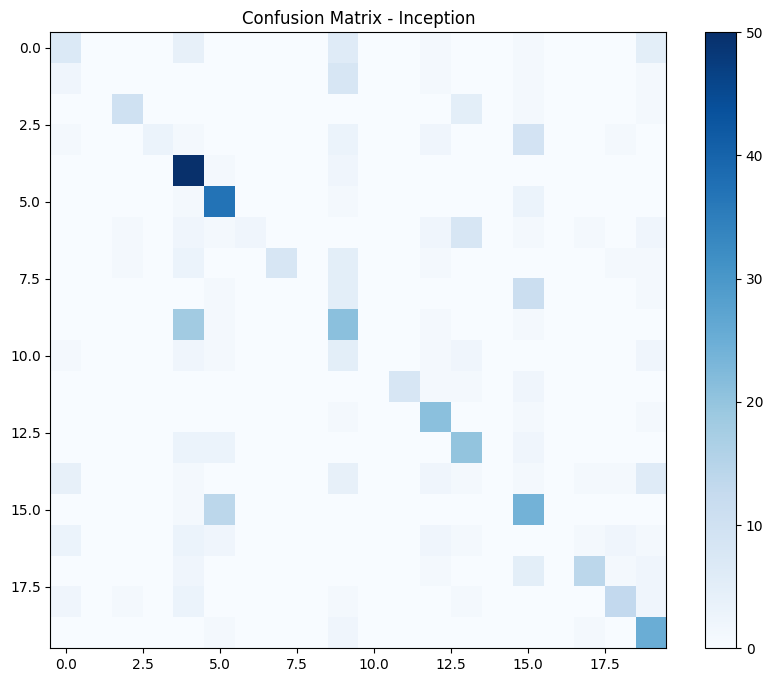

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix - Inception")
plt.colorbar()
plt.show()


**Precision / Recall / F1**

In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score


print("Precision:", precision_score(y_true, y_pred, average='weighted', zero_division=0))
print("Recall:", recall_score(y_true, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_true, y_pred, average='weighted'))

print("\nClassification Report:\n")
print(classification_report(
    y_true,
    y_pred,
    target_names=test_loader_inc.dataset.classes,
    zero_division=0
))


Precision: 0.5078388423516679
Recall: 0.5270541082164328
F1 Score: 0.4652776040049445

Classification Report:

                   precision    recall  f1-score   support

             Golf       0.35      0.29      0.32        24
      bmw serie 1       0.00      0.00      0.00        13
  chevrolet spark       0.77      0.59      0.67        17
  chevroulet aveo       1.00      0.15      0.26        20
             clio       0.53      0.94      0.68        53
           duster       0.60      0.88      0.71        42
      hyundai i10       1.00      0.10      0.18        20
   hyundai tucson       1.00      0.40      0.57        20
            logan       0.00      0.00      0.00        18
           megane       0.33      0.50      0.40        42
 mercedes class a       0.00      0.00      0.00        14
     nemo citroen       1.00      0.67      0.80        12
          octavia       0.58      0.88      0.70        24
          picanto       0.51      0.71      0.60        28
   

**ROC & AUC**

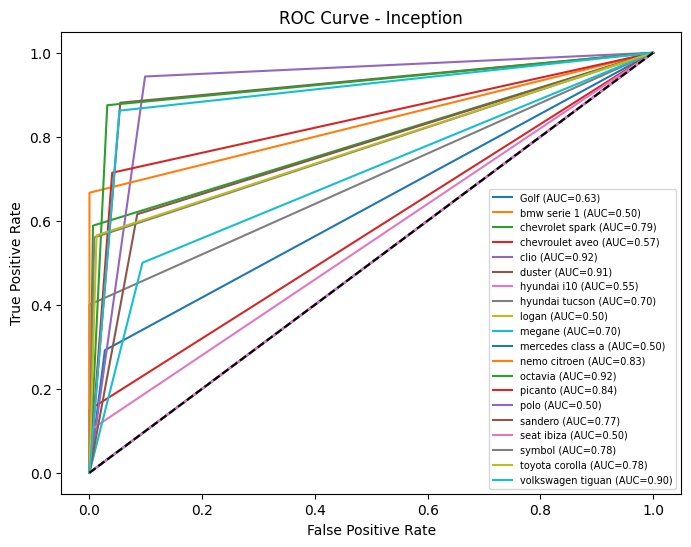

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

class_names = test_loader_inc.dataset.classes
num_classes = len(class_names)

y_true_bin = label_binarize(y_true, classes=range(num_classes))
y_pred_bin = label_binarize(y_pred, classes=range(num_classes))

fpr, tpr, roc_auc = {}, {}, {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,6))

for i in range(num_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        label=f'{class_names[i]} (AUC={roc_auc[i]:.2f})'
    )

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Inception')
plt.legend(fontsize=7)
plt.show()


**Model VGG-19 from scratch**

In [9]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

IMAGE_SIZE = 224
BATCH_SIZE = 32

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder("/content/data/train", transform=train_transform)
val_dataset   = datasets.ImageFolder("/content/data/val", transform=val_transform)
test_dataset  = datasets.ImageFolder("/content/data/test", transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

num_classes = len(train_dataset.classes)
print("Num Classes:", num_classes)


Num Classes: 20


**Using weights = None to be acctually from scratch**

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

model = models.vgg19(weights=None)

model.classifier[6] = nn.Linear(
    model.classifier[6].in_features,
    num_classes
)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Device: cuda


**Training Loop**

In [15]:
from tqdm import tqdm

EPOCHS = 20

for epoch in range(EPOCHS):
    model.train()
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    print(f"Epoch [{epoch+1}/{EPOCHS}] - Train Accuracy: {train_acc:.4f}")


100%|██████████| 71/71 [00:46<00:00,  1.51it/s]


Epoch [1/20] - Train Accuracy: 0.1063


100%|██████████| 71/71 [00:45<00:00,  1.56it/s]


Epoch [2/20] - Train Accuracy: 0.1063


100%|██████████| 71/71 [00:45<00:00,  1.55it/s]


Epoch [3/20] - Train Accuracy: 0.1067


100%|██████████| 71/71 [00:45<00:00,  1.57it/s]


Epoch [4/20] - Train Accuracy: 0.1063


100%|██████████| 71/71 [00:45<00:00,  1.57it/s]


Epoch [5/20] - Train Accuracy: 0.1041


100%|██████████| 71/71 [00:45<00:00,  1.57it/s]


Epoch [6/20] - Train Accuracy: 0.1063


100%|██████████| 71/71 [00:45<00:00,  1.57it/s]


Epoch [7/20] - Train Accuracy: 0.1063


100%|██████████| 71/71 [00:44<00:00,  1.58it/s]


Epoch [8/20] - Train Accuracy: 0.1063


100%|██████████| 71/71 [00:44<00:00,  1.58it/s]


Epoch [9/20] - Train Accuracy: 0.1045


100%|██████████| 71/71 [00:45<00:00,  1.57it/s]


Epoch [10/20] - Train Accuracy: 0.1041


100%|██████████| 71/71 [00:45<00:00,  1.58it/s]


Epoch [11/20] - Train Accuracy: 0.1063


100%|██████████| 71/71 [00:45<00:00,  1.57it/s]


Epoch [12/20] - Train Accuracy: 0.1054


100%|██████████| 71/71 [00:45<00:00,  1.58it/s]


Epoch [13/20] - Train Accuracy: 0.1067


100%|██████████| 71/71 [00:44<00:00,  1.58it/s]


Epoch [14/20] - Train Accuracy: 0.1063


100%|██████████| 71/71 [00:45<00:00,  1.57it/s]


Epoch [15/20] - Train Accuracy: 0.1050


100%|██████████| 71/71 [00:44<00:00,  1.58it/s]


Epoch [16/20] - Train Accuracy: 0.1072


100%|██████████| 71/71 [00:44<00:00,  1.58it/s]


Epoch [17/20] - Train Accuracy: 0.1063


100%|██████████| 71/71 [00:45<00:00,  1.58it/s]


Epoch [18/20] - Train Accuracy: 0.1058


100%|██████████| 71/71 [00:45<00:00,  1.58it/s]


Epoch [19/20] - Train Accuracy: 0.1063


100%|██████████| 71/71 [00:44<00:00,  1.58it/s]

Epoch [20/20] - Train Accuracy: 0.1067


**Test Accuracy + Confusion Matrix**

Test Accuracy (VGG-19): 0.1062124248496994


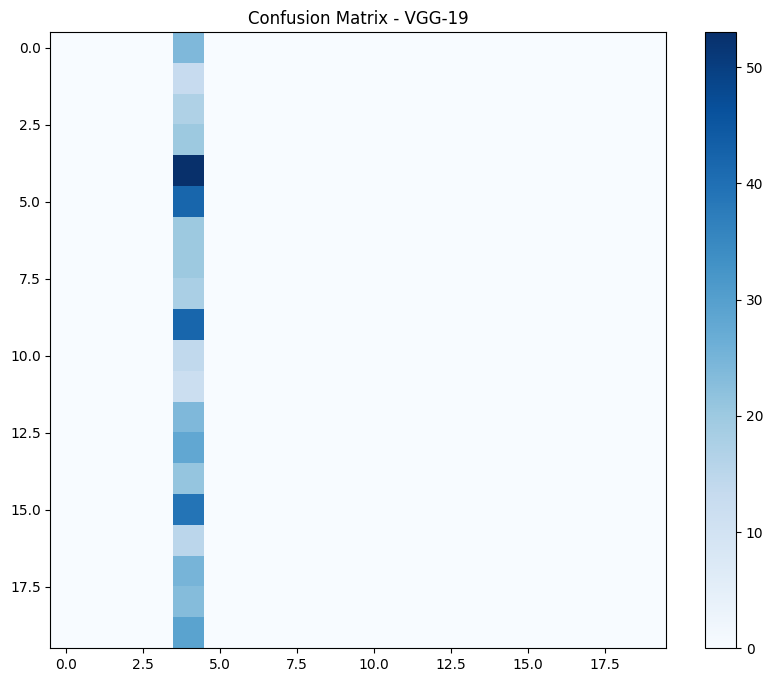

In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = outputs.argmax(1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
print("Test Accuracy (VGG-19):", acc)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix - VGG-19")
plt.colorbar()
plt.show()


**Precision / Recall / F1**

In [18]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

print("Precision:", precision_score(y_true, y_pred, average='weighted', zero_division=0))
print("Recall:", recall_score(y_true, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_true, y_pred, average='weighted'))

print("\nClassification Report:\n")
print(classification_report(
    y_true,
    y_pred,
    target_names=test_loader.dataset.classes,
    zero_division=0
))


Precision: 0.011281079192453042
Recall: 0.1062124248496994
F1 Score: 0.02039586419215242

Classification Report:

                   precision    recall  f1-score   support

             Golf       0.00      0.00      0.00        24
      bmw serie 1       0.00      0.00      0.00        13
  chevrolet spark       0.00      0.00      0.00        17
  chevroulet aveo       0.00      0.00      0.00        20
             clio       0.11      1.00      0.19        53
           duster       0.00      0.00      0.00        42
      hyundai i10       0.00      0.00      0.00        20
   hyundai tucson       0.00      0.00      0.00        20
            logan       0.00      0.00      0.00        18
           megane       0.00      0.00      0.00        42
 mercedes class a       0.00      0.00      0.00        14
     nemo citroen       0.00      0.00      0.00        12
          octavia       0.00      0.00      0.00        24
          picanto       0.00      0.00      0.00        28


**ROC & AUC**

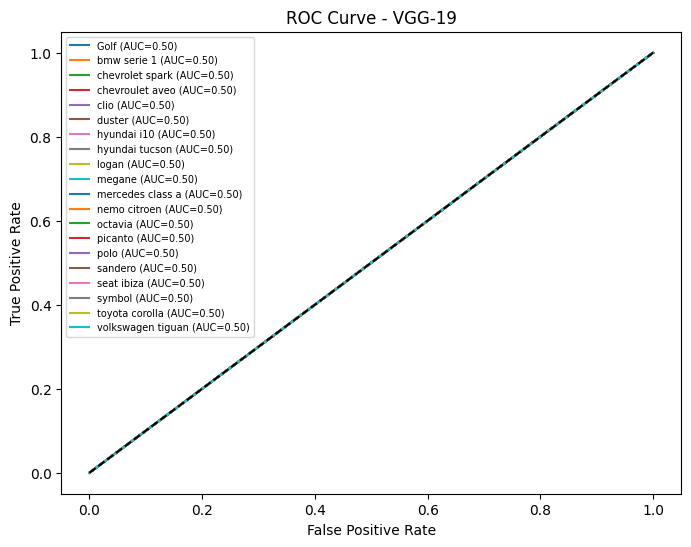

In [19]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

class_names = test_loader.dataset.classes
num_classes = len(class_names)

y_true_bin = label_binarize(y_true, classes=range(num_classes))
y_pred_bin = label_binarize(y_pred, classes=range(num_classes))

fpr, tpr, roc_auc = {}, {}, {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC={roc_auc[i]:.2f})')

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - VGG-19')
plt.legend(fontsize=7)
plt.show()
